In [22]:
import argparse
import os
import sys
from functools import partial
from tqdm import tqdm
import json
from types import SimpleNamespace

# Simulate having cfg available by loading in hydra config as dict
import yaml
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

import pyrootutils
import dgl
import dgl.function as fn
import hydra
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import MeanMetric
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import BinaryAUROC, BinaryAveragePrecision
from sklearn import metrics

import pandas as pd
import scipy.stats as st
from IPython.display import clear_output

user_net_id = os.getlogin()
home_path = '/scratch/' + user_net_id + '/projects/NYU-Zillow-Capstone-2022-Team-A'
if home_path not in sys.path:
    sys.path.append('/scratch/' + user_net_id + '/projects/NYU-Zillow-Capstone-2022-Team-A')

from src.datamodules.negative_sampler import NegativeSampler
from src.model.SAGE import SAGE

In [23]:
def to_bidirected_with_reverse_mapping(g):
    """Makes a graph bidirectional, and returns a mapping array ``mapping`` where ``mapping[i]``
    is the reverse edge of edge ID ``i``. Does not work with graphs that have self-loops.
    """
    g_simple, mapping = dgl.to_simple(
        dgl.add_reverse_edges(g), return_counts="count", writeback_mapping=True
    )
    c = g_simple.edata["count"]
    num_edges = g.num_edges()
    mapping_offset = torch.zeros(g_simple.num_edges() + 1, dtype=g_simple.idtype)
    mapping_offset[1:] = c.cumsum(0)
    idx = mapping.argsort()
    idx_uniq = idx[mapping_offset[:-1]]
    reverse_idx = torch.where(
        idx_uniq >= num_edges, idx_uniq - num_edges, idx_uniq + num_edges
    )
    reverse_mapping = mapping[reverse_idx]
    # sanity check
    src1, dst1 = g_simple.edges()
    src2, dst2 = g_simple.find_edges(reverse_mapping)
    assert torch.equal(src1, dst2)
    assert torch.equal(src2, dst1)
    return g_simple, reverse_mapping


class NegativeSamplerTest(object):
    def __init__(self, g, k, max_img_id, keyword_as_src, neg_share=False):
        self.weights = g.in_degrees().float() ** 0.75
        self.k = k
        self.neg_share = neg_share
        self.max_img_id = max_img_id
        self.keyword_as_src = keyword_as_src

    def __call__(self, g, eids):
        src, _ = g.find_edges(eids)
        if self.keyword_as_src == False:
            img_node_mask = src <= self.max_img_id
            src = src[img_node_mask]
        n = len(src)

        if self.neg_share and n % self.k == 0:
            dst = self.weights.multinomial(n, replacement=True)
            dst = dst.view(-1, 1, self.k).expand(-1, self.k, -1).flatten()
        else:
            dst = self.weights.multinomial(n * self.k, replacement=True)
            
        src = src.repeat_interleave(self.k)
        return src, dst

class DataModule(LightningDataModule):
    def __init__(
        self,
        csv_dataset_root,
        modal_node_ids_file,
        keyword_as_src=False,
        data_cpu=False,
        fan_out=[10, 25],
        device="cpu",
        batch_size=1024,
        num_workers=4,
        force_reload=False,
    ):
        super().__init__()
        self.save_hyperparameters()
        dataset = dgl.data.CSVDataset(csv_dataset_root, force_reload=force_reload)
        g = dataset[0]
        g_bid, reverse_eids = to_bidirected_with_reverse_mapping(g)
        g_bid = g_bid.to(device)
        g = g.to(device)
        reverse_eids = reverse_eids.to(device)

        max_img_id = max(json.load(open(modal_node_ids_file, 'r'))['images'])

        train_nid = torch.nonzero(g_bid.ndata["train_mask"], as_tuple=True)[0].to(device)
        val_nid = torch.nonzero(g_bid.ndata["val_mask"], as_tuple=True)[0].to(device)
        test_nid = torch.nonzero(
            ~(g_bid.ndata["train_mask"] | g_bid.ndata["val_mask"]), as_tuple=True
        )[0].to(device)

        sampler = dgl.dataloading.MultiLayerNeighborSampler(
            [int(_) for _ in fan_out], prefetch_node_feats=["feat"]
        )

        self.g = g
        self.g_bid = g_bid
        self.train_nid, self.val_nid, self.test_nid = train_nid, val_nid, test_nid
        self.sampler = sampler
        self.device = device
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.in_dim = g_bid.ndata["feat"].shape[1]
        self.reverse_eids = reverse_eids
        self.max_img_id = max_img_id
        self.keyword_as_src = keyword_as_src


    def train_dataloader(self):
        edge_sampler = dgl.dataloading.as_edge_prediction_sampler(
            self.sampler,
            exclude='reverse_id',
            reverse_eids=self.reverse_eids,
            negative_sampler=NegativeSamplerTest(self.g, 1, self.max_img_id, self.keyword_as_src)
        )

        train_subgraph = self.g_bid.subgraph(self.train_nid)
        train_u, train_v = train_subgraph.edges()
        train_eids = train_subgraph.edata['_ID'][train_subgraph.edge_ids(train_u, train_v)]

        return dgl.dataloading.DataLoader(
            self.g_bid,
            train_eids,
            edge_sampler,
            device=self.device,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=False
        )

    def val_dataloader(self):
        edge_sampler = dgl.dataloading.as_edge_prediction_sampler(
            self.sampler,
        )

        val_subgraph = self.g_bid.subgraph(self.val_nid)
        val_u, val_v = val_subgraph.edges()
        val_eids = val_subgraph.edata['_ID'][val_subgraph.edge_ids(val_u, val_v)]

        return dgl.dataloading.DataLoader(
            self.g_bid,
            val_eids,
            edge_sampler,
            device=self.device,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False
        )
    
    def test_dataloader(self):
        edge_sampler = dgl.dataloading.as_edge_prediction_sampler(
            self.sampler,
        )

        test_subgraph = self.g_bid.subgraph(self.test_nid)
        test_u, test_v = test_subgraph.edges()
        test_eids = test_subgraph.edata['_ID'][test_subgraph.edge_ids(test_u, test_v)]

        return dgl.dataloading.DataLoader(
            self.g_bid,
            test_eids,
            edge_sampler,
            device=self.device,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=False,
        )

class ScorePredictor(nn.Module):
    def forward(self, edge_subgraph, x):
        with edge_subgraph.local_scope():
            edge_subgraph.ndata["h"] = x
            edge_subgraph.ndata['h_norm'] = F.normalize(x, p=2, dim=-1)
            edge_subgraph.apply_edges(fn.u_dot_v("h_norm", "h_norm", "score"))
            return edge_subgraph.edata["score"]

class SAGELightning(LightningModule):
    def __init__(
        self,
        in_dim,
        h_dim,
        n_layers=3,
        activation=F.relu,
        dropout=0,
        sage_conv_method="mean",
        lr=0.0005,
        batch_size=1024,
    ):
        super().__init__()
        self.module = SAGE(
            in_dim, h_dim, n_layers, activation, dropout, sage_conv_method
        )
        self.lr = lr
        self.predictor = ScorePredictor()
        self.batch_size = batch_size
        self.save_hyperparameters()

        self.train_loss = MeanMetric()
        self.mean_val_positive_score = MeanMetric()
    
    def forward(self, graph, blocks, x):
        self.module(graph, blocks, x)

    def training_step(self, batch, batch_idx):
        input_nodes, pos_graph, neg_graph, blocks = batch
        x = blocks[0].srcdata["feat"]
        logits = self.module(blocks, x)
        pos_score = self.predictor(pos_graph, logits)
        neg_score = self.predictor(neg_graph, logits)

        score = torch.cat([pos_score, neg_score])
        pos_label = torch.ones_like(pos_score)
        neg_label = torch.zeros_like(neg_score)
        labels = torch.cat([pos_label, neg_label])
        loss = F.binary_cross_entropy_with_logits(score, labels)

        return loss

    def validation_step(self, batch, batch_idx):
        input_nodes, pos_graph, blocks = batch
        x = blocks[0].srcdata["feat"]
        logits = self.module(blocks, x)
        pos_score = self.predictor(pos_graph, logits)
        pos_label = torch.ones_like(pos_score)
        self.mean_val_positive_score(pos_score)

        self.log(
            "mean_val_positive_score",
            self.mean_val_positive_score,
            prog_bar=True,
            on_step=False,
            on_epoch=True,
            batch_size=self.batch_size,
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [24]:
class NestedNamespace(SimpleNamespace):
    def __init__(self, dictionary, **kwargs):
        super().__init__(**kwargs)
        for key, value in dictionary.items():
            if isinstance(value, dict):
                self.__setattr__(key, NestedNamespace(value))
            else:
                self.__setattr__(key, value)

root_path = pyrootutils.find_root(search_from='train_graphsage_explore.ipynb', indicator=".git")
print('Set WD location to', root_path)
pyrootutils.set_root(
    path=root_path,
    project_root_env_var=True,
    dotenv=True,
    pythonpath=True,
    cwd=True
)

cfg = NestedNamespace(yaml.load(open('conf/config.yaml'), Loader=Loader))

if not torch.cuda.is_available():
    device = "cpu"
else:
    device = "cuda"

FileNotFoundError: search_from path does not exist.

In [25]:
# Vanilla Graph Training
org = 'zillow'

if org == 'coco':
    csv_dataset_root = cfg.data.coco_graph_root
elif org == 'zillow':
    csv_dataset_root = cfg.data.zillow_root

modal_node_ids_file = os.path.join(csv_dataset_root,'modal_node_ids.json')
datamodule = DataModule(
    csv_dataset_root, 
    modal_node_ids_file, 
    keyword_as_src=False, 
    device=device, 
    batch_size=cfg.training.batch_size, 
    force_reload=False
)

model = SAGELightning(
    datamodule.in_dim,
    cfg.model.hidden_dim,
    n_layers=cfg.model.n_layers,
    batch_size=cfg.training.batch_size,
)

checkpoint_callback = ModelCheckpoint(
    monitor="mean_val_positive_score", save_top_k=1, mode="max"
)
trainer = Trainer(accelerator="gpu", max_epochs=10, callbacks=[checkpoint_callback])
trainer.fit(model, datamodule=datamodule)

Done loading data from cached files.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type           | Params
-----------------------------------------------------------
0 | module                  | SAGE           | 1.6 M 
1 | predictor               | ScorePredictor | 0     
2 | train_loss              | MeanMetric     | 0     
3 | mean_val_positive_score | MeanMetric     | 0     
-----------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.298     Total estimated model params size (MB)


/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:135: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(
/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/lightning_lite/utilities/data.py:63: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate

Epoch 9: 100%|██████████| 227/227 [00:03<00:00, 70.10it/s, loss=0.472, v_num=441, mean_val_positive_score=0.688]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 227/227 [00:03<00:00, 70.07it/s, loss=0.472, v_num=441, mean_val_positive_score=0.688]


In [26]:
###############################################################
#### Build train + validation eval_graph, where we connect ####
#### val and train subgraph by introducing edges between   ####
#### images in each subgraph based on cosine similarity    ####
###############################################################

# Step 1: Initialize val and eval subgraph
val_subgraph = datamodule.g_bid.subgraph(datamodule.val_nid)
eval_subgraph = datamodule.g_bid.subgraph(datamodule.train_nid)

print('val and eval keyword node IDs:')
print(val_subgraph.ndata['_ID'][(val_subgraph.ndata['ntype']==1).nonzero().squeeze()])
print(eval_subgraph.ndata['_ID'][(eval_subgraph.ndata['ntype']==1).nonzero().squeeze()])

# Step 2: Add all nodes from val_subgraph to eval_subgraph (no edges yet - these will be added based on cosine similarity)
val_img_node_idxs = (val_subgraph.ndata['ntype'] == 0).nonzero().squeeze()
val_img_embeds = val_subgraph.ndata['feat'][val_img_node_idxs]
val_img_node_ids = val_subgraph.ndata['_ID'][val_img_node_idxs]
print('number of val img nodes:', len(val_img_node_ids))

val_nodes_data = {'train_mask': torch.zeros(len(val_img_node_ids), dtype=torch.uint8).to(device),
                  'val_mask': torch.ones(len(val_img_node_ids), dtype=torch.uint8).to(device),
                  'test_mask': torch.zeros(len(val_img_node_ids), dtype=torch.uint8).to(device),
                  'ntype': torch.zeros(len(val_img_node_ids), dtype=torch.int64).to(device),
                  'feat': val_img_embeds.to(device),
                  '_ID': val_img_node_ids}

eval_subgraph.add_nodes(num=len(val_img_node_ids), data=val_nodes_data)

# Step 3: Identify image node pairs as edges

eval_train_img_node_idxs = ((eval_subgraph.ndata['ntype'] == 0)&(eval_subgraph.ndata['train_mask']==1)).nonzero().squeeze()
eval_val_img_node_idxs = ((eval_subgraph.ndata['ntype'] == 0)&(eval_subgraph.ndata['val_mask']==1)).nonzero().squeeze()
eval_train_img_embeds = eval_subgraph.ndata['feat'][eval_train_img_node_idxs]
eval_val_img_embeds = eval_subgraph.ndata['feat'][eval_val_img_node_idxs]

cosine_sims_matrix = metrics.pairwise.cosine_similarity(eval_val_img_embeds.cpu().detach().numpy(), 
                                                        eval_train_img_embeds.cpu().detach().numpy())
sim_threshold = 0.975
        
image_matches = []
for cosine_sims in tqdm(cosine_sims_matrix, desc='computing image matches'):
    eval_train_node_id_matches = eval_train_img_node_idxs[(cosine_sims>sim_threshold)]
    if len(eval_train_node_id_matches) == 0:
        eval_train_node_id_matches = eval_train_img_node_idxs[np.argmax(cosine_sims)].unsqueeze(0)
    image_matches.append(eval_train_node_id_matches.tolist())

matches_per_img = [len(matches) for matches in image_matches]
print('match stats:')
print(f'min matches: {np.min(matches_per_img)}')
print(f'max matches: {np.max(matches_per_img)}')
print(f'avg matches: {np.mean(matches_per_img)}')
print(f'std matches: {np.std(matches_per_img)}')
print(f'total new edges to add: {sum(matches_per_img)*2}')

# Step 4: Add the edges to eval_subgraph

u = []
v = []

for i in range(len(image_matches)):
    val_img_node = eval_val_img_node_idxs[i].item()
    train_img_matches = image_matches[i]
    for node_id in train_img_matches:
        train_img_node = node_id
        # Add bidirectional edge for each match
        u += [val_img_node, train_img_node]
        v += [train_img_node, val_img_node]

edge_data = {'_ID': torch.arange(torch.max(eval_subgraph.edata['_ID'])+1, torch.max(eval_subgraph.edata['_ID'])+1+len(u), dtype=torch.int64).to(device)}
eval_subgraph.add_edges(torch.LongTensor(u).to(device), torch.LongTensor(v).to(device), data=edge_data)
eval_subgraph = eval_subgraph.add_self_loop()
eval_subgraph

val and eval keyword node IDs:
tensor([82720, 82721, 82722,  ..., 84249, 84250, 84251], device='cuda:0')
tensor([82720, 82721, 82722,  ..., 84249, 84250, 84251], device='cuda:0')
number of val img nodes: 12496


computing image matches: 100%|██████████| 12496/12496 [00:02<00:00, 5027.80it/s]


match stats:
min matches: 1
max matches: 414
avg matches: 6.366437259923176
std matches: 22.694494916935167
total new edges to add: 159110


Graph(num_nodes=71651, num_edges=421169,
      ndata_schemes={'feat': Scheme(shape=(512,), dtype=torch.float32), 'test_mask': Scheme(shape=(), dtype=torch.uint8), 'ntype': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.uint8), 'train_mask': Scheme(shape=(), dtype=torch.uint8), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'count': Scheme(shape=(), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [27]:
# Step 5: Turn DGL graph into DataLoader object for GraphSAGE forward inference

u_eval, v_eval = eval_subgraph.edges()
eval_subgraph_eids = eval_subgraph.edge_ids(u_eval, v_eval)
layer_sampler = dgl.dataloading.NeighborSampler(fanouts=[10]) # During message passing between GNN layers, each node accept messages from a maximum of 25 incoming nodes
batch_size = len(eval_subgraph.edges()[0])

def eval_dataloader(g, layer_sampler, batch_size, eids):
    edge_sampler = dgl.dataloading.as_edge_prediction_sampler(layer_sampler)

    return dgl.dataloading.DataLoader(
        g,
        eids,
        edge_sampler,
        device=device,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
        # num_workers=self.num_workers,
    )

eval_dl = eval_dataloader(eval_subgraph, layer_sampler, batch_size, eval_subgraph_eids)


In [28]:
# Step 6: Run graphSAGE forward inference over entire val_subgraph message flow graph (MFG)

for batch in eval_dl:
    # This loop only runs once b/c batch_size = number of total edges in train_val_subgraph - we only need it to get "blocks"
    inputs, edge_subgraph, blocks = batch
    
x = blocks[0].srcdata["feat"]
model = model.to(device)
logits = model.module(blocks, x)

eval_subgraph.ndata['feat_pred_norm'] = F.normalize(logits, p=2, dim=-1)
print(eval_subgraph)

Graph(num_nodes=71651, num_edges=421169,
      ndata_schemes={'feat': Scheme(shape=(512,), dtype=torch.float32), 'test_mask': Scheme(shape=(), dtype=torch.uint8), 'ntype': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.uint8), 'train_mask': Scheme(shape=(), dtype=torch.uint8), '_ID': Scheme(shape=(), dtype=torch.int64), 'feat_pred_norm': Scheme(shape=(512,), dtype=torch.float32)}
      edata_schemes={'count': Scheme(shape=(), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)})


In [29]:
# Step 7: Extract validation image features and keyword features for 
eval_val_img_node_ids = ((eval_subgraph.ndata['val_mask']==1)&(eval_subgraph.ndata['ntype']==0)).nonzero().squeeze()
eval_keyword_node_ids = ((eval_subgraph.ndata['ntype']==1)).nonzero().squeeze()

# Post-GraphSAGE embeddings
eval_val_img_feat_sage = eval_subgraph.ndata['feat_pred_norm'][eval_val_img_node_ids]
eval_keyword_feat_sage = eval_subgraph.ndata['feat_pred_norm'][eval_keyword_node_ids]

# Original CLIP embeddings before GraphSAGE forward method
eval_subgraph.ndata['feat_norm'] = F.normalize(eval_subgraph.ndata['feat'], p=2, dim=-1)
eval_val_img_feat_clip = eval_subgraph.ndata['feat_norm'][eval_val_img_node_ids]
eval_keyword_feat_clip = eval_subgraph.ndata['feat_norm'][eval_keyword_node_ids]

print(eval_val_img_feat_sage.size())
print(eval_keyword_feat_sage.size())

torch.Size([12496, 512])
torch.Size([1532, 512])


In [30]:
# Step 8: Compute cosine similarities between validation images and keywords to get "link scores" between 0 and 1

val_sage_link_scores = metrics.pairwise.cosine_similarity(eval_keyword_feat_sage.cpu().detach().numpy(),
                                                          eval_val_img_feat_sage.cpu().detach().numpy())
val_clip_link_scores = metrics.pairwise.cosine_similarity(eval_keyword_feat_clip.cpu().detach().numpy(),
                                                          eval_val_img_feat_clip.cpu().detach().numpy())

print('link scores shape:', val_sage_link_scores.shape)

link scores shape: (1532, 12496)


In [31]:
# Step 9: Get true labels for each keyword from validation subgraph adjacency matrix
# Adjacency matrix needs to be sub-setted such that rows correspond only to image nodes and columns correspond only to keyword nodes
val_img_indices = (val_subgraph.ndata['ntype']==0).nonzero().cpu().reshape(1, -1)
val_keyword_indices = (val_subgraph.ndata['ntype']==1).nonzero().cpu().reshape(-1, 1)

val_adj_matrix = val_subgraph.adjacency_matrix().to_dense().numpy()
val_adj_matrix = val_adj_matrix[val_keyword_indices, val_img_indices]
print('adjacency matrix (ground truth) shape:', val_adj_matrix.shape)

adjacency matrix (ground truth) shape: (1532, 12496)


In [32]:
# Sanity check node IDs for val and eval subgraphs
print('adj matrix col indices used to get images:', val_img_indices.squeeze())
print('adj matrix row indices used to get keywords:', val_keyword_indices.squeeze())
print('OG node IDs represented by val image indices:', val_subgraph.ndata['_ID'][val_img_indices].squeeze())
print('OG node IDs represented by eval image indices:', eval_subgraph.ndata['_ID'][eval_val_img_node_ids])
print('OG node IDs represented by val keyword indices:', val_subgraph.ndata['_ID'][val_keyword_indices].squeeze())
print('OG node IDs represented by eval keyword indices:', eval_subgraph.ndata['_ID'][eval_keyword_node_ids])


adj matrix col indices used to get images: tensor([    0,     1,     2,  ..., 12493, 12494, 12495])
adj matrix row indices used to get keywords: tensor([12496, 12497, 12498,  ..., 14025, 14026, 14027])
OG node IDs represented by val image indices: tensor([   10,    15,    18,  ..., 82711, 82713, 82717], device='cuda:0')
OG node IDs represented by eval image indices: tensor([   10,    15,    18,  ..., 82711, 82713, 82717], device='cuda:0')
OG node IDs represented by val keyword indices: tensor([82720, 82721, 82722,  ..., 84249, 84250, 84251], device='cuda:0')
OG node IDs represented by eval keyword indices: tensor([82720, 82721, 82722,  ..., 84249, 84250, 84251], device='cuda:0')


In [34]:
# Step 10: Make predictions based on prediction threshold and get precision, recall, and accuracy 
pred_thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
sage_clip_metrics = pd.DataFrame()

for pred_threshold in pred_thresholds:
    val_sage_link_predictions = (val_sage_link_scores > pred_threshold).astype(int)
    val_clip_link_predictions = (val_clip_link_scores > pred_threshold).astype(int)

    results_dict = {'sage': {'precision': np.empty(len(val_sage_link_predictions)),
                            'recall': np.empty(len(val_sage_link_predictions))},
                    'clip': {'precision': np.empty(len(val_sage_link_predictions)),
                            'recall': np.empty(len(val_sage_link_predictions))}}

    weights = np.empty(len(val_sage_link_predictions))

    for i in range(len(val_sage_link_predictions)):
        sage_tp = np.sum(((val_sage_link_predictions[i]==1)&(val_adj_matrix[i]==1)))
        sage_p = np.sum(val_sage_link_predictions[i])
        
        clip_tp = np.sum(((val_clip_link_predictions[i]==1)&(val_adj_matrix[i]==1)))
        clip_p = np.sum(val_clip_link_predictions[i])

        true_p = np.sum(val_adj_matrix[i])
        
        results_dict['sage']['precision'][i] = sage_tp / sage_p if sage_p > 0 else 0
        results_dict['clip']['precision'][i] = clip_tp / clip_p if clip_p > 0 else 0
        results_dict['sage']['recall'][i] = sage_tp / true_p if true_p > 0 else 0
        results_dict['clip']['recall'][i] = clip_tp / true_p if true_p > 0 else 0

        weights[i] = true_p

    weights /= np.sum(weights)

    for method in results_dict.keys():
        row = {'threshold': pred_threshold, 'method': method}
        for metric in results_dict[method]:
            row[f'{metric}_micro'] = np.mean(results_dict[method][metric]*weights)
            row[f'{metric}_macro'] = np.mean(results_dict[method][metric])
        sage_clip_metrics = pd.concat([sage_clip_metrics, pd.DataFrame([row])], ignore_index=True)

print('Metrics:')
print(sage_clip_metrics.head(10))

Metrics:
   threshold method  precision_micro  precision_macro  recall_micro  \
0       0.40   sage         0.000004         0.000410      0.000160   
1       0.40   clip         0.000058         0.007014      0.000539   
2       0.45   sage         0.000004         0.000413      0.000101   
3       0.45   clip         0.000008         0.001414      0.000001   
4       0.50   sage         0.000004         0.000412      0.000066   
5       0.50   clip         0.000000         0.000000      0.000000   
6       0.55   sage         0.000004         0.000409      0.000048   
7       0.55   clip         0.000000         0.000000      0.000000   
8       0.60   sage         0.000004         0.000420      0.000038   
9       0.60   clip         0.000000         0.000000      0.000000   

   recall_macro  
0      0.170425  
1      0.451483  
2      0.105597  
3      0.002072  
4      0.068622  
5      0.000000  
6      0.051036  
7      0.000000  
8      0.038380  
9      0.000000  


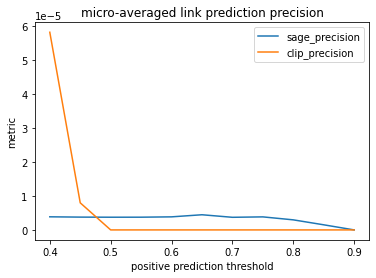

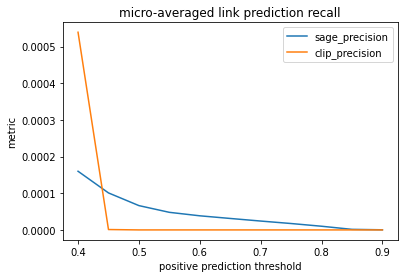

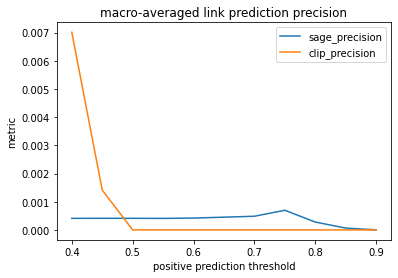

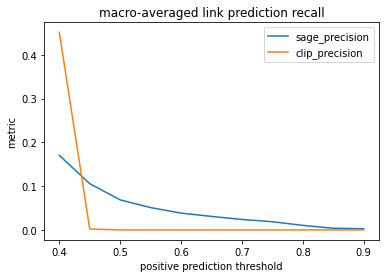

In [40]:
import matplotlib.pyplot as plt

sage_micro_threshold_metrics = sage_clip_metrics[sage_clip_metrics['method']=='sage'][['threshold', 'precision_micro', 'recall_micro']]
clip_micro_threshold_metrics = sage_clip_metrics[sage_clip_metrics['method']=='clip'][['threshold', 'precision_micro', 'recall_micro']]
sage_macro_threshold_metrics = sage_clip_metrics[sage_clip_metrics['method']=='sage'][['threshold', 'precision_macro', 'recall_macro']]
clip_macro_threshold_metrics = sage_clip_metrics[sage_clip_metrics['method']=='sage'][['threshold', 'precision_macro', 'recall_macro']]


for avg_type in ['micro', 'macro']:
    legend = []
    for metric in ['precision', 'recall']:
        for method in ['sage', 'clip']:
            plt.plot(sage_clip_metrics[sage_clip_metrics['method']==method]['threshold'], 
                    sage_clip_metrics[sage_clip_metrics['method']==method][f'{metric}_{avg_type}'])
            legend += [f'{method}_{metric}']
        plt.legend(legend)
        plt.xlabel('positive prediction threshold')
        plt.ylabel('metric')
        plt.title(f'{avg_type}-averaged link prediction {metric}')
        plt.show()


In [65]:
# Side quest: check out how nodes with only self loops change in terms of their embeddings after running graphSAGE forward

eval_subgraph_keyword_nodes = (eval_subgraph.ndata['ntype']==1).nonzero().squeeze()
u, v = eval_subgraph.edges()
uv = torch.cat((u,v))

only_self_loops = []
for node in tqdm(eval_subgraph_keyword_nodes):
    count = torch.sum((uv==node))
    if count == 2:
        only_self_loops.append(node.item())

print(eval_subgraph.ndata['feat_norm'][only_self_loops[0]][:10])
print(eval_subgraph.ndata['feat_pred_norm'][only_self_loops[0]][:10])


100%|██████████| 1532/1532 [00:00<00:00, 15040.81it/s]

tensor([ 0.0180,  0.0257, -0.0215, -0.0374,  0.0009,  0.0196,  0.0055, -0.0895,
         0.0094, -0.0379], device='cuda:0')
tensor([0.0000, 0.0000, 0.0127, 0.0534, 0.0000, 0.0055, 0.0000, 0.1418, 0.0272,
        0.0000], device='cuda:0', grad_fn=<SliceBackward0>)
